# Table of Contents

1. [Imports](#1.-Imports)
2. [Exploritory Data Analysis](#2.-Exploritory-Data-Analysis)
3. [Baseline with ARIMA model](#3.-Baseline-with-ARIMA-model) 
4. [Evaluating TFT model using the electricity dataset](#4.-Evaluating-TFT-model-using-the-electricity-dataset)
5. [Evaluating NeuralProphete using the electricity dataset](#5.-Evaluating-NeuralProphete-using-the-electricity-dataset)
6. [Conclusion](#6.-Conclusion)
7. [Bibliography](#7.-Bibliography)


# 1. Imports

In [1]:
import torch
import pytorch_lightning as pl
import tensorboard as tb
import json
import time
import warnings
from torch import nn
from pytorch_lightning.accelerators import *
from torch.utils.tensorboard import SummaryWriter
from lightning.pytorch.accelerators import find_usable_cuda_devices
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataloading_helpers import electricity_dataloader
from config import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as Arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pandas as pd
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape
from statistics import mean, median
from neuralprophet import NeuralProphet, set_log_level, set_random_seed, save, load

# 2. Exploritory Data Analysis

In the following we will take a short look into the electricity dataset.
To not create bias, we will just look at the train dataset.
Because the dataset is not too complex, we will mostly look at the distribution of the target value.

First you can see a small overview over the dataset in the following outputs. Because the dataset has already gone through the preprocessing, provided in the google paper, 
no missing values are present and the only step missing is standardizing and/or normalizing the data.

The first distribution-plot leads to the assumption, that we have many small values and not that much big ones. 
After log-transformation, we can assume, that even thou we have very small and very big values, the target variable is still in a very scewed normal distribution.

In [83]:
# load dataset as pandas df, hint with underscore, that test/validation should not be used
train, _, _ = electricity_dataloader.create_electricity_dataframe_not_normalized()  
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1923536 entries, 17544 to 10460742
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   power_usage              float64
 1   time_idx                 int32  
 2   days_from_start          int64  
 3   categorical_id           object 
 4   date                     object 
 5   id                       object 
 6   hour                     int64  
 7   day                      int64  
 8   day_of_week              int64  
 9   month                    int64  
 10  hours_from_start         float64
 11  categorical_day_of_week  int64  
 12  categorical_hour         int64  
dtypes: float64(2), int32(1), int64(7), object(3)
memory usage: 198.1+ MB


In [84]:
# check for NaNs
train.isnull().sum().any()

False

In [16]:
train.head()

,power_usage,time_idx,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,2.538071,26304,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
17545,2.855330,26305,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
17546,2.855330,26306,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
17547,2.855330,26307,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
17548,2.538071,26308,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4


C:\Users\Benedikt\anaconda_main\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


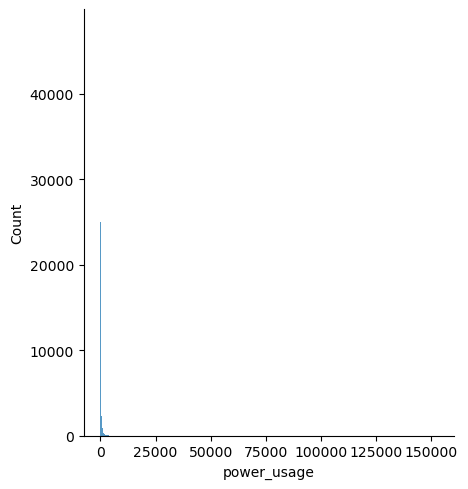

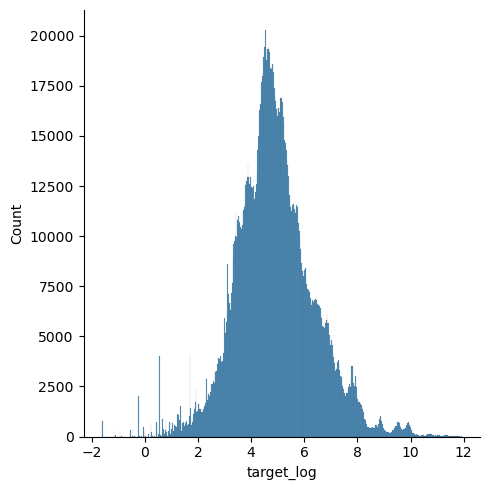

In [44]:
train["target_log"] = np.log(train['power_usage'])
target = sns.displot(data=train, x="power_usage", bins=20)
log_target = sns.displot(data=train, x="target_log")
plt.show()

There are 369 different ids present in the dataset. When looking at different ids and their mean and standard deviation, we can assume, that the distribution in the target variable is there due to different distribution for each id and not because each id represents the distribution of the target vairable. Therefore making id-specific normalization even more imporatant. 

In [47]:
print(f"Number of unique ids: {train["categorical_id"].nunique()}.")

369

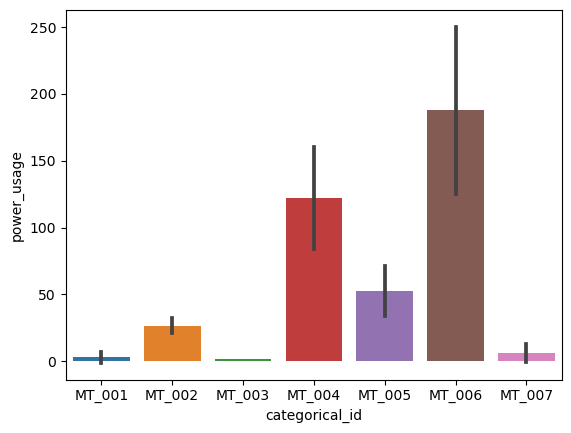

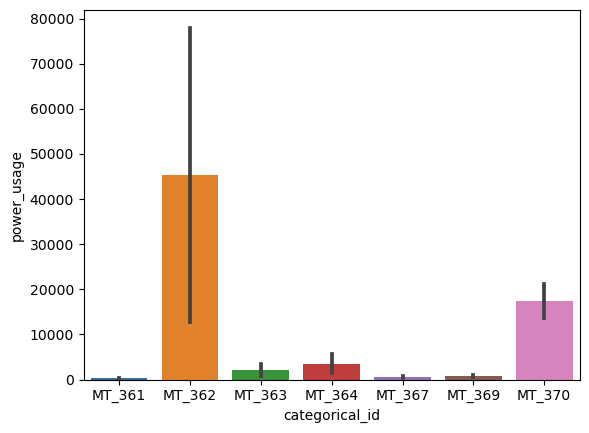

In [82]:
small_ids = ['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007']
big_ids =    ['MT_361', 'MT_362', 'MT_363', 'MT_364','MT_367', 'MT_369', 'MT_370']

small_train = train[train["categorical_id"].isin(small_ids)]
big_train = train[train["categorical_id"].isin(big_ids)]
        
def visualize_id_target(df):
    sns.barplot(x="categorical_id", y="power_usage", data=df, ci='sd')
    df.groupby(['categorical_id']).mean()['power_usage']
    df.groupby(['categorical_id']).std()['power_usage']
    plt.show()

visualize_id_target(small_train)
visualize_id_target(big_train)

# 3. Baseline with ARIMA model

We will use the AutoRegressionIntegratedMovingAverage-model, to get a first understanding what performance can be expected with the electricity dataset.
For comparability, we use the same pre-processing as for the TFT model.
ARIMA is not intendet to be a global model [1] and in the EDA part, we showed, that there is a big divergence between the different id-specific timeseries. 
Thus, the most sensible solution is, to fit 369 ARIMA-models on the respective data to achieve more specific predictions.

Before starting off, we need to have a look at indicators on wheather a timeseries needs to be differenced to be stationary. Stationary meaning, that the
general strucure of the data does not change over time. This can be indicated by the mean, standard deviation and auto-correlation.

Because auto-arima handles this automatically, this is just to get an idea, if all, some, or none of the timeseries needs to be differenced.

C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


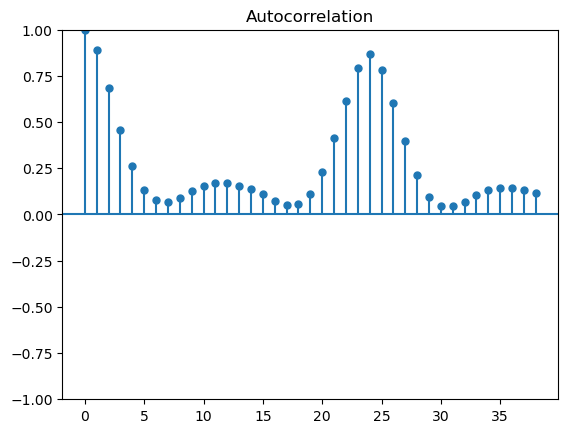

C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


This timeseries needs to be adjusted.


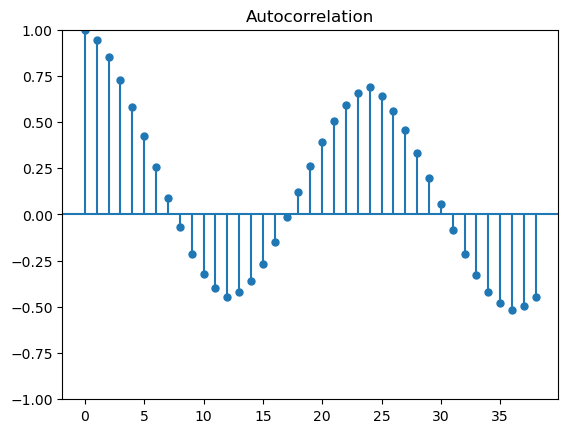

This timeseries needs to be adjusted.


C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


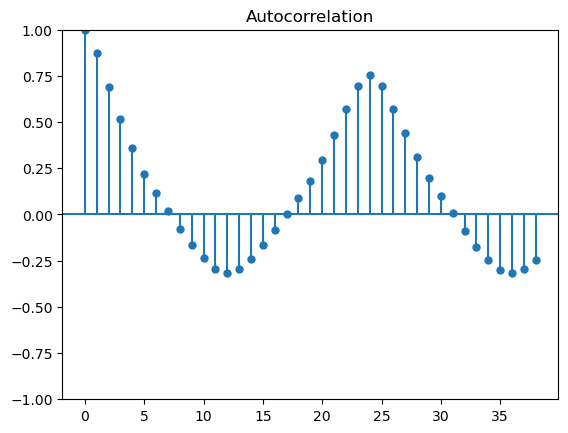

This timeseries needs to be adjusted.


In [26]:
train, _, _ = electricity_dataloader.create_electricity_timeseries_np()

x1 = train[train["categorical_id"] == "18"]["power_usage"].array
x2 = train[train["categorical_id"] == "155"]["power_usage"].array
x3 = train[train["categorical_id"] == "350"]["power_usage"].array

def eval_differenced(target_array):
    Arima.plot_acf(target_array)
    # Test whether we should difference at the alpha=0.05, significance level
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(target_array)  # (0.01, False)

    # Estimate the number of differences using an ADF test:
    n_adf = ndiffs(target_array, test='adf')  # -> 0

    # Or a KPSS test (auto_arima default):
    n_kpss = ndiffs(target_array, test='kpss')  # -> 0

    # Or a PP test:
    n_pp = ndiffs(target_array, test='pp')  # -> 0
    if not n_adf == n_kpss == n_pp == 0 & should_diff == False:
        print("This timeseries needs to be adjusted.")
        
eval_differenced(x1)
eval_differenced(x2)
eval_differenced(x3)

As you can see, some timeseries are already stationary, some still need to be transformed. Plotted on the x-axis is time in hours, on the y-axis we can see the autocorrelation term.
Now we will fit one ARIMA model per timeseries. We have already learned from the TFT variable importance, that time of day is a more imporatant measure over all timeseries than day of week and month, thus we will give the auto-ARIMA the information, that we want to model seasonality over 24 timesteps, representing a full day. 
In the following you can see an example plot for the prediction. This visualization gives us an idea, if the model does actually learn what it is intendet to. The question can be answered with a clear yes. 

C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


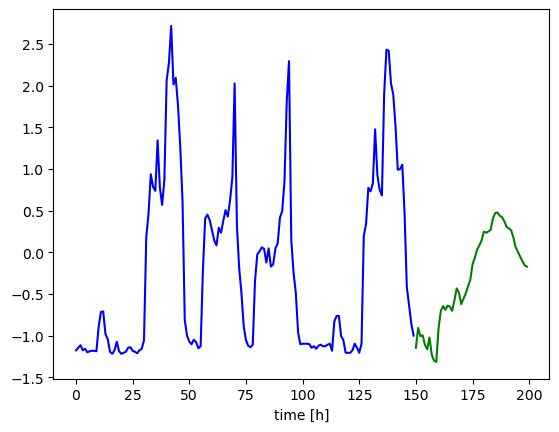

In [49]:
df, test, val = electricity_dataloader.create_electricity_timeseries_np()

# select id to look at
single_id = "366"

df_array = df[df["categorical_id"] == single_id]

train_limit=150

df_array = df_array[:200]
train_split, test_split = train_test_split(df_array, train_size=train_limit)
                                          
# Fit your model
model = Arima.auto_arima(train_split[["power_usage"]], exogenous=train_split[['categorical_hour', "categorical_day_of_week", "time_idx"]], stepwise=True, seasonal=True, m=24)

# make your forecasts
forecasts, confidence = model.predict(test_split.shape[0], return_conf_int=True, exogenous=test_split[['categorical_hour', "categorical_day_of_week", "time_idx"]])  # predict N steps into the future
                          
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_array.shape[0])
plt.plot(x[:train_limit], train_split["power_usage"].array, c='blue')
plt.plot(x[train_limit:], forecasts, c='green')
plt.xlabel("time [h]")
plt.ylabel("normalized power consumption")
plt.show()

As a first trial, we are just using the test data. Fitting on all, except for the last 24 timesteps, and using those for evaluation of the models. 
Over the first 11 ids, we can observe a MAE of 0.349, which is a slightly worse performance than our prelimenary TFT results with 0.329.

When fitting on the full train dataset, updating the model with the same input as used in the sanity checking, we get a comparable performance. 
Some models perform better, some worse.

Because we have to fit 369 models, letting each model look at all the possible data does not seem feasable with one fit taking around 30 minutes, leading to a potentiall training time of around a week.
As a first step we set the optimization steps to a maximum of 15, down from 50. This is recommended as a good trade off between time and performance in the documentation.
In case the training time is still the limiting factor, we will look into decreasing the size of training data.

Literature [2] is suggesting, that sometimes between 50 and 150 datapoints can already be enough. This number is supposed to be strongly linked to the number of datapoints per season. 
With our assumption of strong daily seasonality, this means we should look at a datasize some factor of 24.
Reducing the training data to around 1400 datapoints, refitting on around 700 datapoints and doing a maximum of 5 optimization runs yields a final fitting time of around 2-6 minutes per timeseries.
This leads to an assumed final runtime of around 20 hours. Given the fact, that no parallelization is used, it can be assumed to be a comparable training investment, compared to the 5 hours of GPU training
of the TFT. Parallization is possible according to the documentation, however a strong recommendation for an iterative approach is made.

To keep comparability in mind, we keep the same time horizon for testing.  

To do the full trainin run, we run the "arima_electricity.py" script. The script writes all id-specific predictions to a csv file, which we load in the following part for evaluating the predictions.

In [158]:
global_preds_arima = pd.read_csv(CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv")
print(f"Mean absolute error over all ids: {mean_absolute_error(global_preds_arima.forecasts , global_preds_arima.test_data_id_predict_y)}")
global_preds_arima

Mean absolute error over all ids: 0.2852771370632379


,id_nr,forecasts,test_data_id_predict_y,global_confidence_upper,global_confidence_lower
0,0,3.205188,3.237144,4.197137,2.213240
1,0,3.184221,3.237144,4.318757,2.049686
2,0,3.222129,3.313606,4.428818,2.015439
3,0,3.207001,3.313606,4.481767,1.932235
4,0,3.210657,3.237144,4.550043,1.871270
...,...,...,...,...,...
6811,284,1.366922,1.150823,1.728109,1.005735
6812,284,1.048553,0.888241,1.409740,0.687366
6813,284,0.759885,0.803837,1.121073,0.398698
6814,284,0.221496,0.110967,0.582683,-0.139691


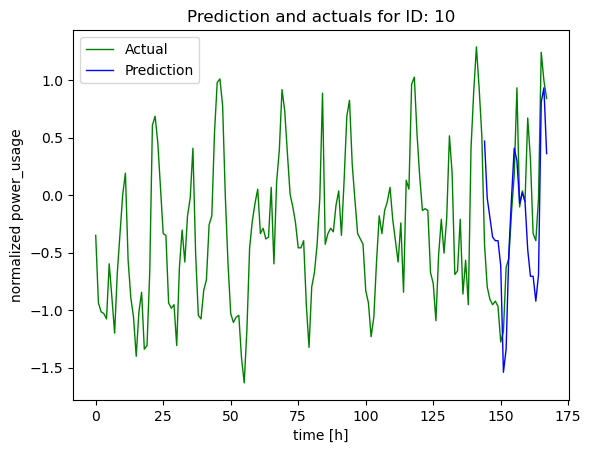

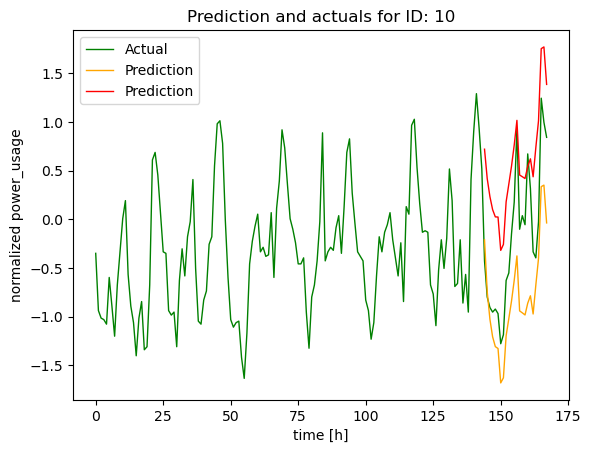

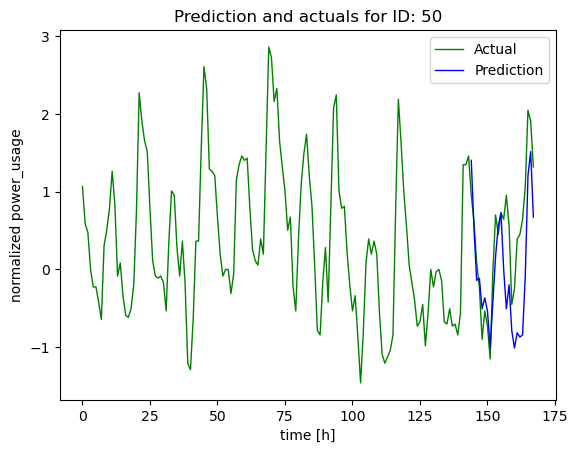

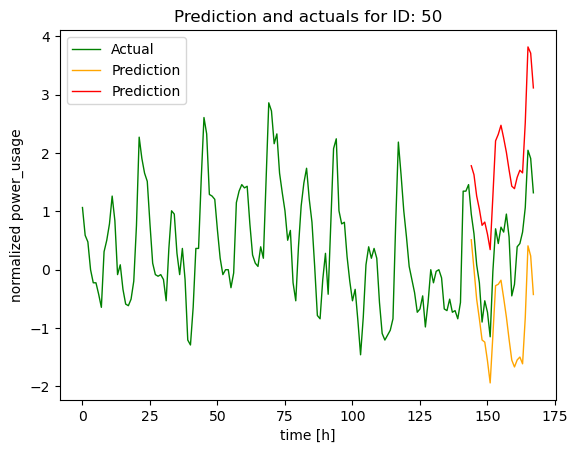

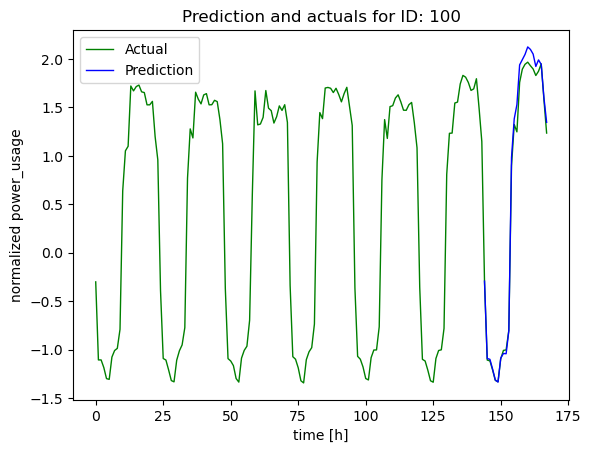

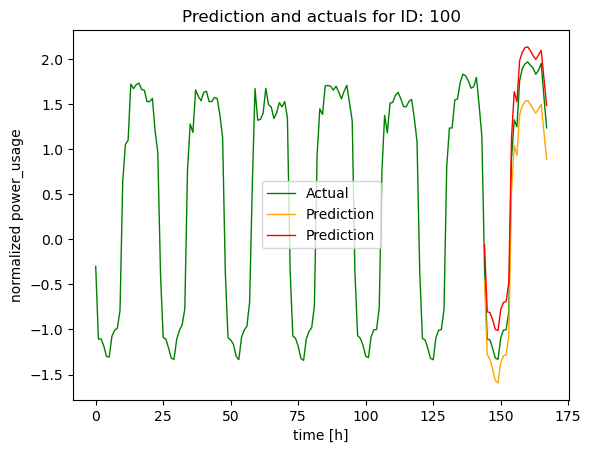

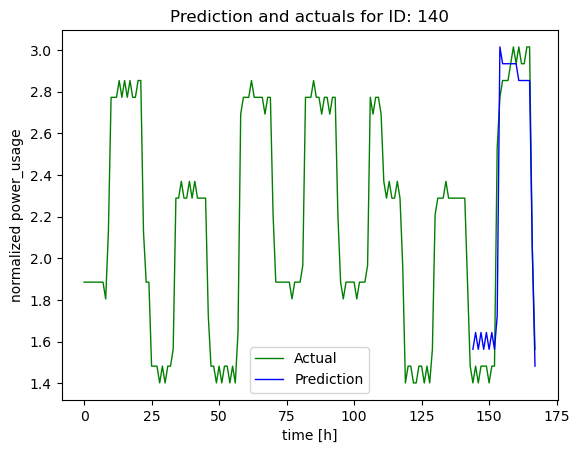

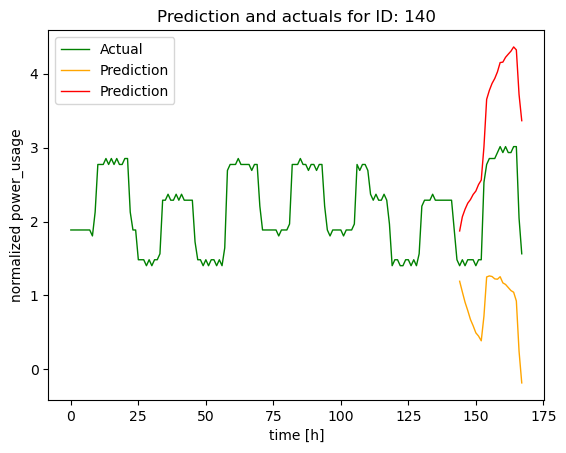

In [119]:
# load predictions and actuals
_, test, _ = electricity_dataloader.create_electricity_timeseries_np()
global_preds_arima = pd.read_csv(CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv")

for id_nr in [10, 50, 100, 140]:
    # select single id
    id_data = global_preds_arima[global_preds_arima["id_nr"] == id_nr]
    id_data_actual = test[test["categorical_id"] == str(id_nr)]

    # reshape to 7 days
    eval_cutoff = id_data_actual["days_from_start"].max() - 1
    index = id_data_actual['days_from_start']
    days_before_prediction = id_data_actual.loc[(index <= eval_cutoff) & (index > (eval_cutoff - 7))] 

    # plot actuals vs preds
    x = np.arange(days_before_prediction.shape[0])
    plt.title(f"Prediction and actuals for ID: {id_nr}")
    plt.plot(x[:], days_before_prediction["power_usage"], c='green', label="Actual", linewidth=1)
    plt.plot(x[144:], id_data["test_data_id_predict_y"], c='blue', label="Prediction", linewidth=1)
    plt.xlabel("time [h]")
    plt.ylabel("normalized power_usage")
    plt.legend()
    
    # uncomment to save to arima output folder
    #plt.savefig(CONFIG_DICT["models"]["electricity"] / "arima" / f"arima_preds_actuals_id_{id_nr}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # plot actuals vs P10/P90
    x = np.arange(days_before_prediction.shape[0])
    plt.title(f"Prediction and actuals for ID: {id_nr}")
    plt.plot(x[:], days_before_prediction["power_usage"], c='green', label="Actual", linewidth=1)
    plt.plot(x[144:], id_data["global_confidence_lower"], c='orange', label="Prediction", linewidth=1)
    plt.plot(x[144:], id_data["global_confidence_upper"], c='red', label="Prediction", linewidth=1)
    plt.xlabel("time [h]")
    plt.ylabel("normalized power_usage")
    plt.legend()
    
    # uncomment to save to arima output folder
    #plt.savefig(CONFIG_DICT["models"]["electricity"] / "arima" / f"arima_preds_confidence_id_{id_nr}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [80]:
# calculate normalized P90 loss
global_preds_arima = pd.read_csv(CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv")

# calculate delta between P90 prediction and actual
delta_90 = global_preds_arima["test_data_id_predict_y"] - global_preds_arima["global_confidence_upper"]
delta_50 = global_preds_arima["test_data_id_predict_y"] - global_preds_arima["forecasts"]
p50_loss_liste = []
p90_loss_liste = []

for i in delta_90:
    p90_loss_liste.append(abs(max(0.9 * i, 0.1 * i)))
for i in delta_50:
    p50_loss_liste.append(abs(0.5 * i))

norm_p90_loss = median(p90_loss_liste)
norm_p50_loss = median(p50_loss_liste)

print("Normalized MAE is: ",(global_preds_arima["test_data_id_predict_y"] - global_preds_arima["forecasts"]).abs().mean())
print(f"Normalized P50-loss is: {norm_p50_loss}.")
print(f"Normalized P90-loss is: {norm_p90_loss}.")



Normalized MAE is:  0.3610757281948275
Normalized P50-loss is: 0.12009035217222125.
Normalized P90-loss is: 0.0721086568713401.


With the TFT-paper reporting a normalized P50-loss of 0.154 and a normalized P90-loss of 0.102 when using the ARIMA model, we are able to show improvements of around 33% on the P50-loss and 26% respectively. 
One significant difference in our training is, that we are refitting the models on the days prior to the prediction horizon, while [3] (p. 1188) is using a rolling window over the test dataset without refitting. 
Our choice might not be a sensible setting for a time-sensitive production enviroment, but arguably accaptable when trying to achieve the best results. One could argue, that the deep learning models get to see the prior datapoints as well. 
One interesting further comparison would be the difference between using multiple lags to incorporate prior weeks data or actually refitting on the prior weeks data.

However, due to the different training we cannot call the improvements significant in any ways, even though they still give a baseline of what performance might possible by our other models.

# 4. Evaluating TFT model using the electricity dataset

After we have run the hyperparameter optimization script and done a full training run with the TFT and the electricity dataset on a server, we can safe the model to our repository. 
Afterwards, we can load the model state with the lowest validaiton loss on a local machine into this notebook and have a closer look into our performance and explainability. We have to instantiate the trainer and model, before loading the model state.

In [70]:
electricity = electricity_dataloader.create_electricity_timeseries_tft()
timeseries_dict =  electricity
config_name_string = "electricity"
parameters = []
model_dir = CONFIG_DICT["models"][config_name_string] / "tft" 

# best parameters estimated by hypertuning and manually rounded
hyper_dict = {
              'gradient_clip_val': 0.052, 
              'hidden_size': 128, 
              'dropout': 0.15, 
              'hidden_continuous_size': 32, 
              'attention_head_size': 2, 
              'learning_rate': 0.007,
              }

if torch.cuda.is_available():
    accelerator = "gpu"
    devices = find_usable_cuda_devices(1)
else:
    accelerator = "cpu"
    devices = None
     
# uncomment to read hyperparamter output from hyper-tuning script
#hyper_dict = pd.read_pickle(CONFIG_DICT["models"]["electricity"] / "tuning_logs" / "tft_hypertuning_electricity.pkl")

# define callbacks, trainer and model, make sure to use save config as the trained model you want to load
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=CONFIG_DICT["models"]["electricity"] / "tft" / "checkpoint_callback_logs",
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
    )

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger(CONFIG_DICT["models"]["electricity"] / "tft")  # logging results to a tensorboard

trainer = pl.Trainer(
    default_root_dir=CONFIG_DICT["models"]["electricity"] / "tft",
    max_epochs=8,
    accelerator=accelerator,
    devices=devices,
    enable_model_summary=True,
    gradient_clip_val=hyper_dict["gradient_clip_val"],
    #limit_train_batches=20, 
    fast_dev_run=False,  
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    log_every_n_steps=1,
    logger=logger,
    profiler="simple",
    )

tft = TemporalFusionTransformer.from_dataset(
    electricity["training_dataset"],
    learning_rate=hyper_dict["learning_rate"],
    hidden_size=hyper_dict["hidden_size"],
    attention_head_size=hyper_dict["attention_head_size"],
    dropout=hyper_dict["dropout"],
    hidden_continuous_size=hyper_dict["hidden_continuous_size"],
    output_size= 3,  
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=1,
    reduce_on_plateau_patience=4,
    optimizer="adam"
    )

tft.load_state_dict(torch.load(CONFIG_DICT["models"]["electricity"] / "tft" / "tft_model_google_normalizer"))

output = trainer.test(model=tft, 
                      dataloaders=electricity["test_dataloader"], 
                      ckpt_path=CONFIG_DICT["models"]["electricity"] / "tft" / "checkpoint_callback_logs" / "sample-mnist-epoch=02-val_loss=0.18.ckpt"
                     )

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more in

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    0.2760344445705414     │
│         test_MAPE         │     1.281701683998108     │
│         test_RMSE         │    0.40894854068756104    │
│        test_SMAPE         │    0.4582216441631317     │
│         test_loss         │    0.1785597801208496     │
└───────────────────────────┴───────────────────────────┘

In [103]:
# predict, select p50 and p90 forecast and calculate loss
#percentile_predictions = tft.predict(timeseries_dict["test_dataloader"], mode="quantiles")
p50_preds = percentile_predictions[:,:,1]
p90_preds = percentile_predictions[:,:,2]

# calculate delta between P90 prediction and actual
delta_90 = actuals - p90_preds
delta_50 = actuals - p50_preds
p50_loss_liste = []
p90_loss_liste = []

delta_90_flattened = delta_90.flatten()
delta_50_flattened = delta_50.flatten()

for i in delta_90_flattened:
    p90_loss_liste.append(abs(max(0.9 * i, 0.1 * i)))
for i in delta_50_flattened:
    p50_loss_liste.append(abs(0.5 * i))

norm_p90_loss = median(p90_loss_liste)
norm_p50_loss = median(p50_loss_liste)

print("Normalized MAE is: ",(actuals - percentile_predictions[:,:,1]).abs().mean().item())
print(f"Normalized P50-loss is: {norm_p50_loss}.")
print(f"Normalized P90-loss is: {norm_p90_loss}.\n")

print(f"MAE improvement of {100*(-1 + (0.3610757281948275 / 0.2760344445705414)):.1f}% compared to the ARIMA model.")
print(f"P50 improvement of {100*(-1 + (0.1200903521722212 / 0.09254078567028046)):.1f}% compared to the ARIMA model.")
print(f"P90 improvement of {100*(-1 + (0.0721086568713401 / 0.046765461564064026)):.1f}% compared to the ARIMA model.")

Normalized MAE is:  0.2760344445705414
Normalized P50-loss is: 0.09254078567028046.
Normalized P90-loss is: 0.046765461564064026.

MAE improvement of 30.8% compared to the ARIMA model.
P50 improvement of 29.8% compared to the ARIMA model.
P90 improvement of 54.2% compared to the ARIMA model.


With the inbuild test-function we can make an evaluation run over the test dataset and get multiple metrics for a first evaluation of the trained model. The test-loss of 0.179 is very similar to the loss encountered during training, leading to the assumption, that the model did not overfit. 

With the ARIMA model having a mormalized MAE of 0.361, we are already able to show a significant improvement with the TFTs normalized test MAE of 0.276.

With the TFT paper reporting a normalized P50-loss of 0.055 and P90-loss of 0.027, we are not able to achieve exactly the same performance. 
While the TFT paper showed an 180% and 278% improvement over the ARIMA losses, we are able to show around 30% and 54%. 
This is still somewhat off shown in the TFT paper, but we are still aple to replicate a signifficantly higher performance improvement in the P90-loss than the P50-loss.

This already highlights the explainability aspect of the TFT, having a higher certainty for the P90 percentile might sometimes be more important to avert risks, than having a very precise point prediction.

In the following we will plot some predictions to get a better understanding of how the model performs on multiple timeseries.
In the first visualization you can see observed and predicted values, alongside 10th ercentile, 90th percentile and the attention score.

Please keep in mind, that the target values are still normalized and the inbuild functions don't allow us to add labels to the visualizations.

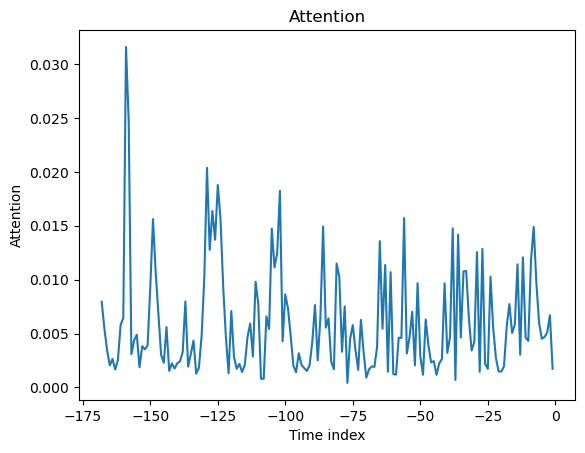

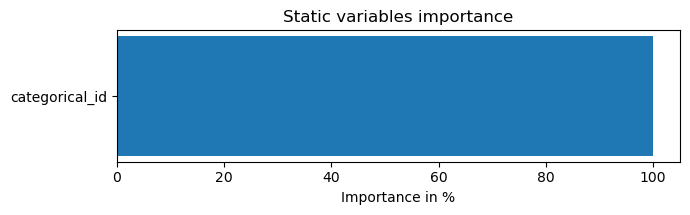

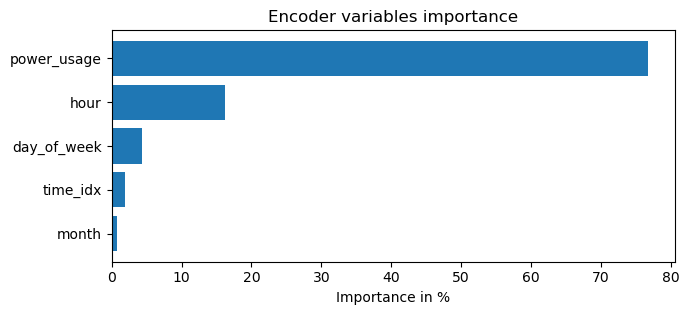

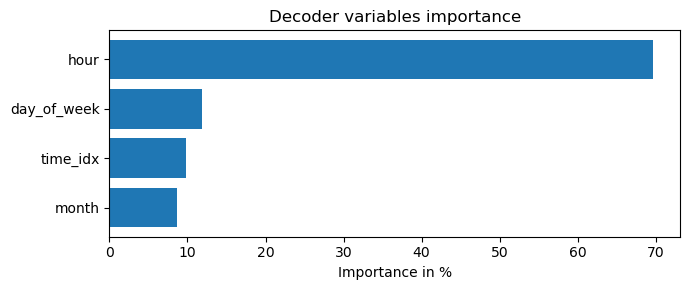

In [129]:
raw_predictions, x = tft.predict(timeseries_dict["test_dataloader"], mode="raw", return_x=True)
interpretation_mean = tft.interpret_output(raw_predictions, reduction="mean")
plot = tft.plot_interpretation(interpretation_mean)

# saving visualizations
plot["attention"].savefig(CONFIG_DICT["models"]["electricity"] / "tft" / "visualizations" / "attention_mean.pdf", format="pdf", bbox_inches="tight")
plot["static_variables"].savefig(CONFIG_DICT["models"]["electricity"] / "tft" / "visualizations" / "static_variable_importance.pdf", format="pdf", bbox_inches="tight")
plot["encoder_variables"].savefig(CONFIG_DICT["models"]["electricity"] / "tft" / "visualizations" / "encoder_variable_importance.pdf", format="pdf", bbox_inches="tight")
plot["decoder_variables"].savefig(CONFIG_DICT["models"]["electricity"] / "tft" / "visualizations" / "decoder_variable_importance.pdf", format="pdf", bbox_inches="tight")

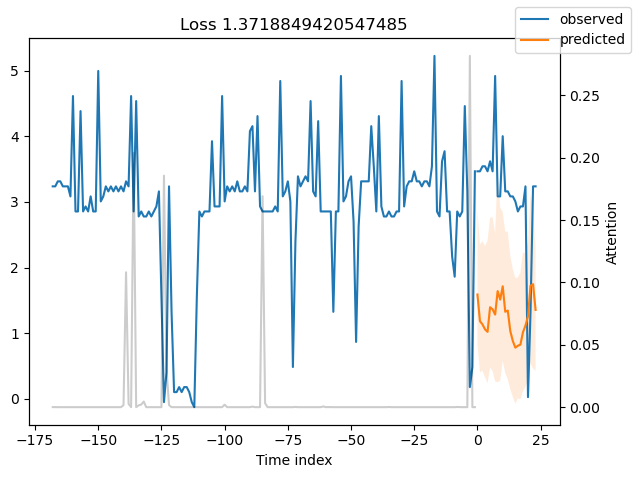

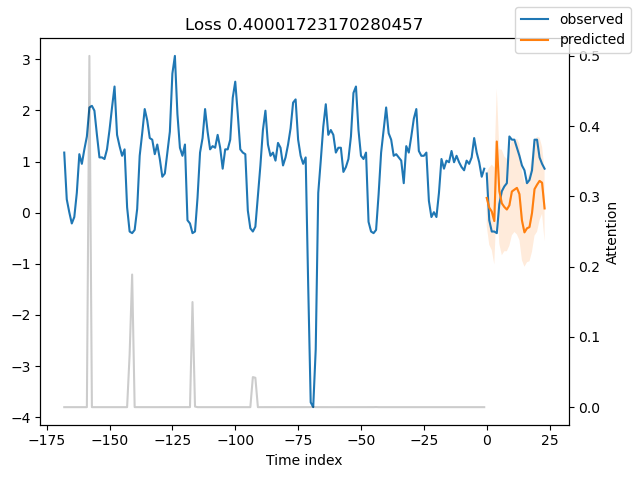

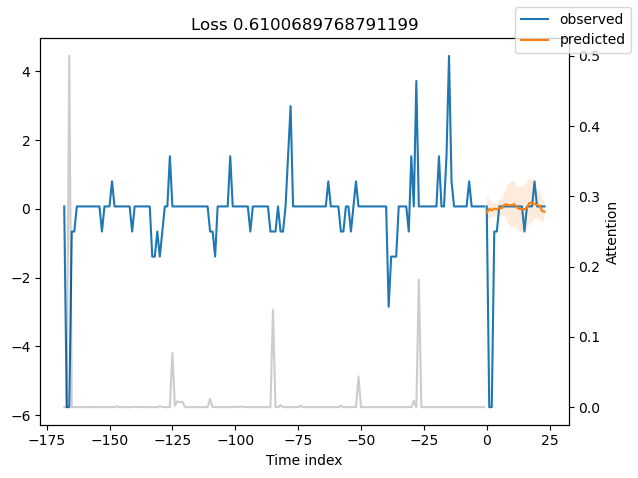

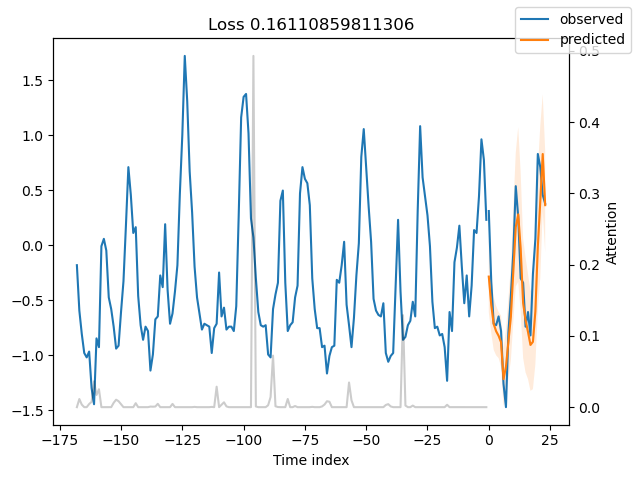

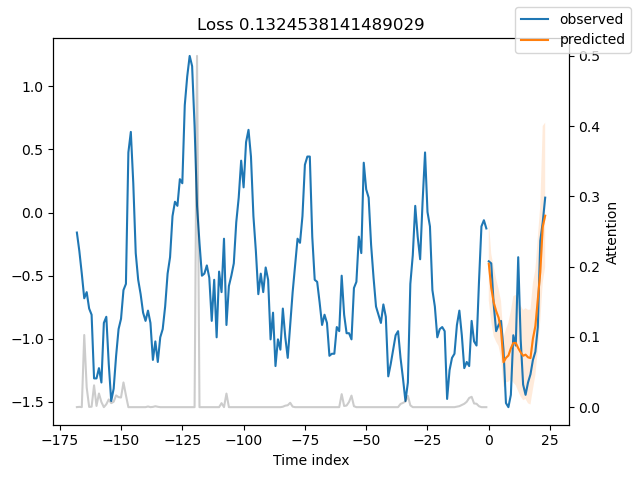

In [127]:
interpretation = tft.interpret_output(raw_predictions)

for idx in range(5):  
    plot = tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plot.savefig(CONFIG_DICT["models"]["electricity"] / "tft" / "visualizations" / f"tft_preds_id_{idx}.pdf", format="pdf", bbox_inches="tight")

In [168]:
predictions = predictions.numpy()

In [171]:
#predictions, x = tft.predict(timeseries_dict["test_dataloader"], return_x=True)

predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
output = tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

NameError: name 'disable' is not defined

# 5. Evaluating NeuralProphete using the electricity dataset

NeuralProphet is bridging the gap between statistical models and global deep-learning models. Joining fourier series for seasonality modeling and neural networks for non-linear auto-regression.
It is one of the models in the forecasting field, that is gaining a lot of traction. The developers just recently published a paper discussing their integration with pytorch-foreacsting and pytorch-lightning.
Showing their intention of making NeuralProphet more accasable, easy to work with and more scalable.

For evaluating the NeuralProphet, we load a model, that has already been fit on the training data, this script is also provided in this repository. Training took around 70 minutes with 10 epoch over the whole data and num_workers set to 40 on a Xeon CPU. After trying many ways for saving the trained model, the only one that actually worked is the inbuild save and load functions. This is also saving the data inside the model, making it too big to save in the repository with 14GB. Also reloading a saved model throws a NoneType error.
Thus we can only save outputs from the model and present those. For exploring explainability, we will fit a second model on a couple of timeseries and explore the insights we can gain from this model.

We process the test data the same way, add the same lagged regressors and finally predict on this dataset.

In [149]:
# loading predictions, training metrics and test dataset to compare
predictions_normalized = pd.read_csv(CONFIG_DICT["models"]["electricity"] / "neuralprophet" / "np_preds_google.csv", index_col=0)
training_metrics = pd.read_csv(CONFIG_DICT["models"]["electricity"] / "neuralprophet" / "np_metrics_google.csv", index_col=0)

_, _, test = electricity_dataloader.create_electricity_timeseries_np()

test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S.%f')
test.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)
test = test[test["ds"] >= "2014-09-01"]

# reformatting y and yhat 
input_columns = ["ID", "y","ds"]                                  # index + target + datetime
future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 
train = train[input_columns + lagged_regressors]    # with regressors
test = test[input_columns + lagged_regressors]    # with regressors
test_last_day_y = test[test["ds"] >= "2014-09-07"]["y"]
y_list = list(test_last_day_y)
test_last_day_preds = predictions_normalized.iloc[167::168,:]    


# select 24 predictions and 24 p90 predictions from predidctions dataset
preds_list = []
p90_list = []
for index, row in test_last_day_preds.iterrows():
    preds_list.extend(row.values[3:27][::-1])
    p90_list.extend(row.values[51:75][::-1])

In [150]:
training_metrics

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,0.499038,0.645185,1.996186,0.0,0,0.356599,0.496480,0.471204,0.0
1,0.726334,0.948035,7.740205,0.0,1,0.728033,0.953747,4.369153,0.0
2,1.343147,1.714342,14.001184,0.0,2,1.230853,1.637567,14.604840,0.0
3,1.825361,2.361774,18.938932,0.0,3,1.307124,1.751605,16.851295,0.0
4,1.183263,1.567281,11.343121,0.0,4,1.162055,1.541629,12.997764,0.0
5,2.383611,3.322458,52.494686,0.0,5,0.939401,1.236822,7.705567,0.0
6,0.785555,0.990633,3.695101,0.0,6,0.692698,0.901262,3.613371,0.0
7,0.640577,0.794415,1.971268,0.0,7,0.492900,0.650414,1.457530,0.0
8,0.350794,0.462318,0.512185,0.0,8,0.358279,0.494987,0.452304,0.0
9,0.359046,0.469045,0.483881,0.0,9,0.272575,0.411506,0.229165,0.0


In [138]:
assert len(preds_list) == len(p90_list) == len(y_list)

In [145]:
# calculate normalized P90 loss

# calculate delta between P90 prediction and actual
delta_90 = [a-b for a,b in zip(y_list, p90_list)]
delta_50 = [a-b for a,b in zip(y_list, preds_list)]

p50_loss_liste = []
p90_loss_liste = []

for i in delta_90:
    p90_loss_liste.append(abs(max(0.9 * i, 0.1 * i)))
for i in delta_50:
    p50_loss_liste.append(abs(0.5 * i))

norm_p90_loss = median(p90_loss_liste)
norm_p50_loss = median(p50_loss_liste)


print(f"Normalized P50-loss is: {norm_p50_loss}.")
print(f"Normalized P90-loss is: {norm_p90_loss}.")

Normalized P50-loss is: 0.45049695224212066.
Normalized P90-loss is: 0.7307293615230053.


In our experience, the normalized losses are usually lower than the MAE and especially a 10-fold increase compared to other baselines in the TFT paper lead to the assumption, that there is a mistake in the implementation. Handling the predictions dataset is already so impractival, that the mistake could have happened here.

For now we cannot validata the performance of the model stated in their publication. Further research is needed and we recommend a reimplementation once NeuralProphet has transfered to Pytorch-Lightning and Pytorch-Forecasting.

In [12]:
# definind model for training on reduced dataset, using build in normalizer
set_log_level("ERROR")

csv_file = CONFIG_DICT["datasets"]["electricity"] / "LD2011_2014.csv"
electricity = pd.read_csv(csv_file, index_col=0)

electricity['date'] =  pd.to_datetime(electricity['date'], format='%Y-%m-%d %H:%M:%S.%f')
electricity.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)

num_id = 1
test_boundary=1339
index = electricity['days_from_start']

train = electricity.loc[(index >= 1100) & (index < test_boundary)]
test = electricity.loc[index >= test_boundary]
test = test[test.ID.isin(test.ID.unique()[:num_id])]
test_explainability = test[test["ds"] >= "2014-09-01"]


# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 

train = train[input_columns + lagged_regressors]    # with regressors
test_explainability = test_explainability[input_columns + lagged_regressors] 

model = NeuralProphet(
        growth = "off",                   
        trend_global_local = "global",
        season_global_local = "global",                
        n_lags = 6*24,                      # autoregressor on last 24h x 6 days
        n_forecasts = 24,                   # forecast horizon
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        learning_rate = 0.05,
        loss_func = "MSE",
        quantiles = [0.1, 0.5, 0.9]  ,
    )
    
model = model.highlight_nth_step_ahead_of_each_forecast(step_number = model.n_forecasts)
model = model.add_lagged_regressor(names = lagged_regressors)  

def split_train_test(df, model, num_id=0, valid_p=0.2):
    '''
    to ran only on part of data (for first # id) :   specify parameter num_id, e.g. num_id=5 (for first 5 ids)
    '''
    if num_id==0:
        df = df
    else:
        df = df[df.ID.isin(df.ID.unique()[:num_id])]
    
    df_train, df_test = model.split_df( 
        df,    
        freq='H',
        valid_p = valid_p,         
        local_split = True
    )
    
    return df_train, df_test

df_train, df_val = split_train_test(train, model, num_id=num_id)


metrics = model.fit(
        df = df_train, 
        validation_df = df_val,
        freq='H', 
        progress="print",
        num_workers = 10,
        #early_stopping=True,
        learning_rate=0.05,
        epochs=1,
        batch_size=64
)

forecast = model.predict(test_explainability, decompose=True)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

In [13]:
forecast

,ds,y,ID,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,...,lagged_regressor_month19,lagged_regressor_month20,lagged_regressor_month21,lagged_regressor_month22,lagged_regressor_month23,lagged_regressor_month24,trend,season_yearly,season_weekly,season_daily
0,2014-09-01 00:00:00,16.180203,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-01 01:00:00,16.497462,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-01 02:00:00,16.180203,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-01 03:00:00,16.497462,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-01 04:00:00,16.180203,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2014-09-07 19:00:00,16.497462,MT_001,15.884201,27.408194,15.637047,18.613602,15.178743,23.298590,18.291552,...,-3.170318,-3.686305,NaN,NaN,NaN,NaN,-6.822312,12.243786,3.965914,-0.716440
164,2014-09-07 20:00:00,3.172589,MT_001,7.538116,14.195781,11.567561,22.883154,13.241149,20.621527,13.692904,...,-3.170318,-3.686305,-2.203098,NaN,NaN,NaN,-6.822312,12.238552,3.685479,-0.444569
165,2014-09-07 21:00:00,8.565990,MT_001,1.642517,7.707813,18.691185,22.287138,19.396461,23.992702,15.413232,...,-3.170318,-3.686305,-2.203098,-2.466179,NaN,NaN,-6.822312,12.233244,3.429972,-0.765455
166,2014-09-07 22:00:00,16.497462,MT_001,7.808621,14.610441,14.104937,21.335564,16.216396,20.567366,9.500916,...,-3.170318,-3.686305,-2.203098,-2.466179,-3.634609,NaN,-6.822312,12.227856,3.203761,-1.623206


matplotlib.figure.Figure

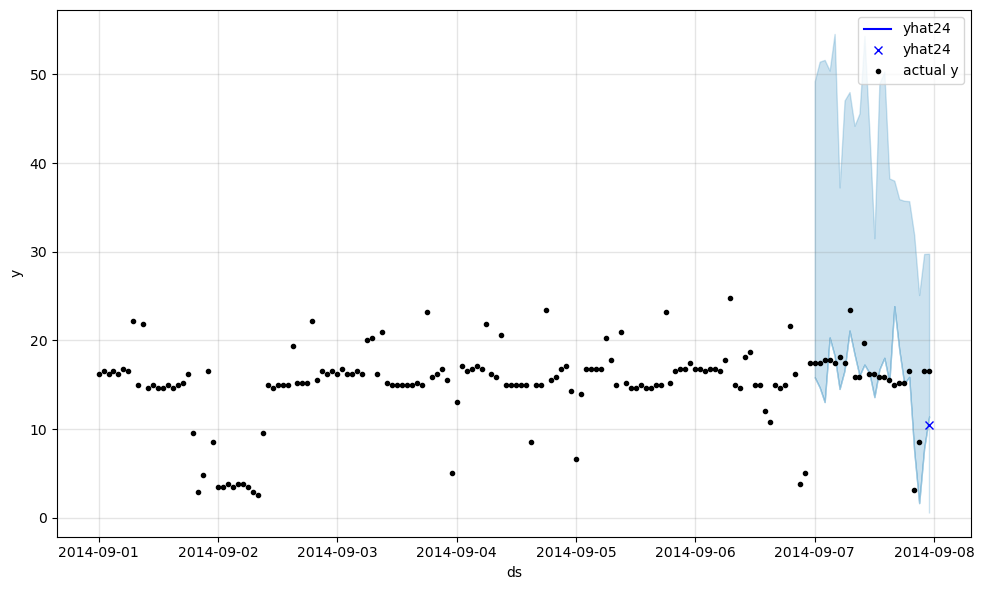

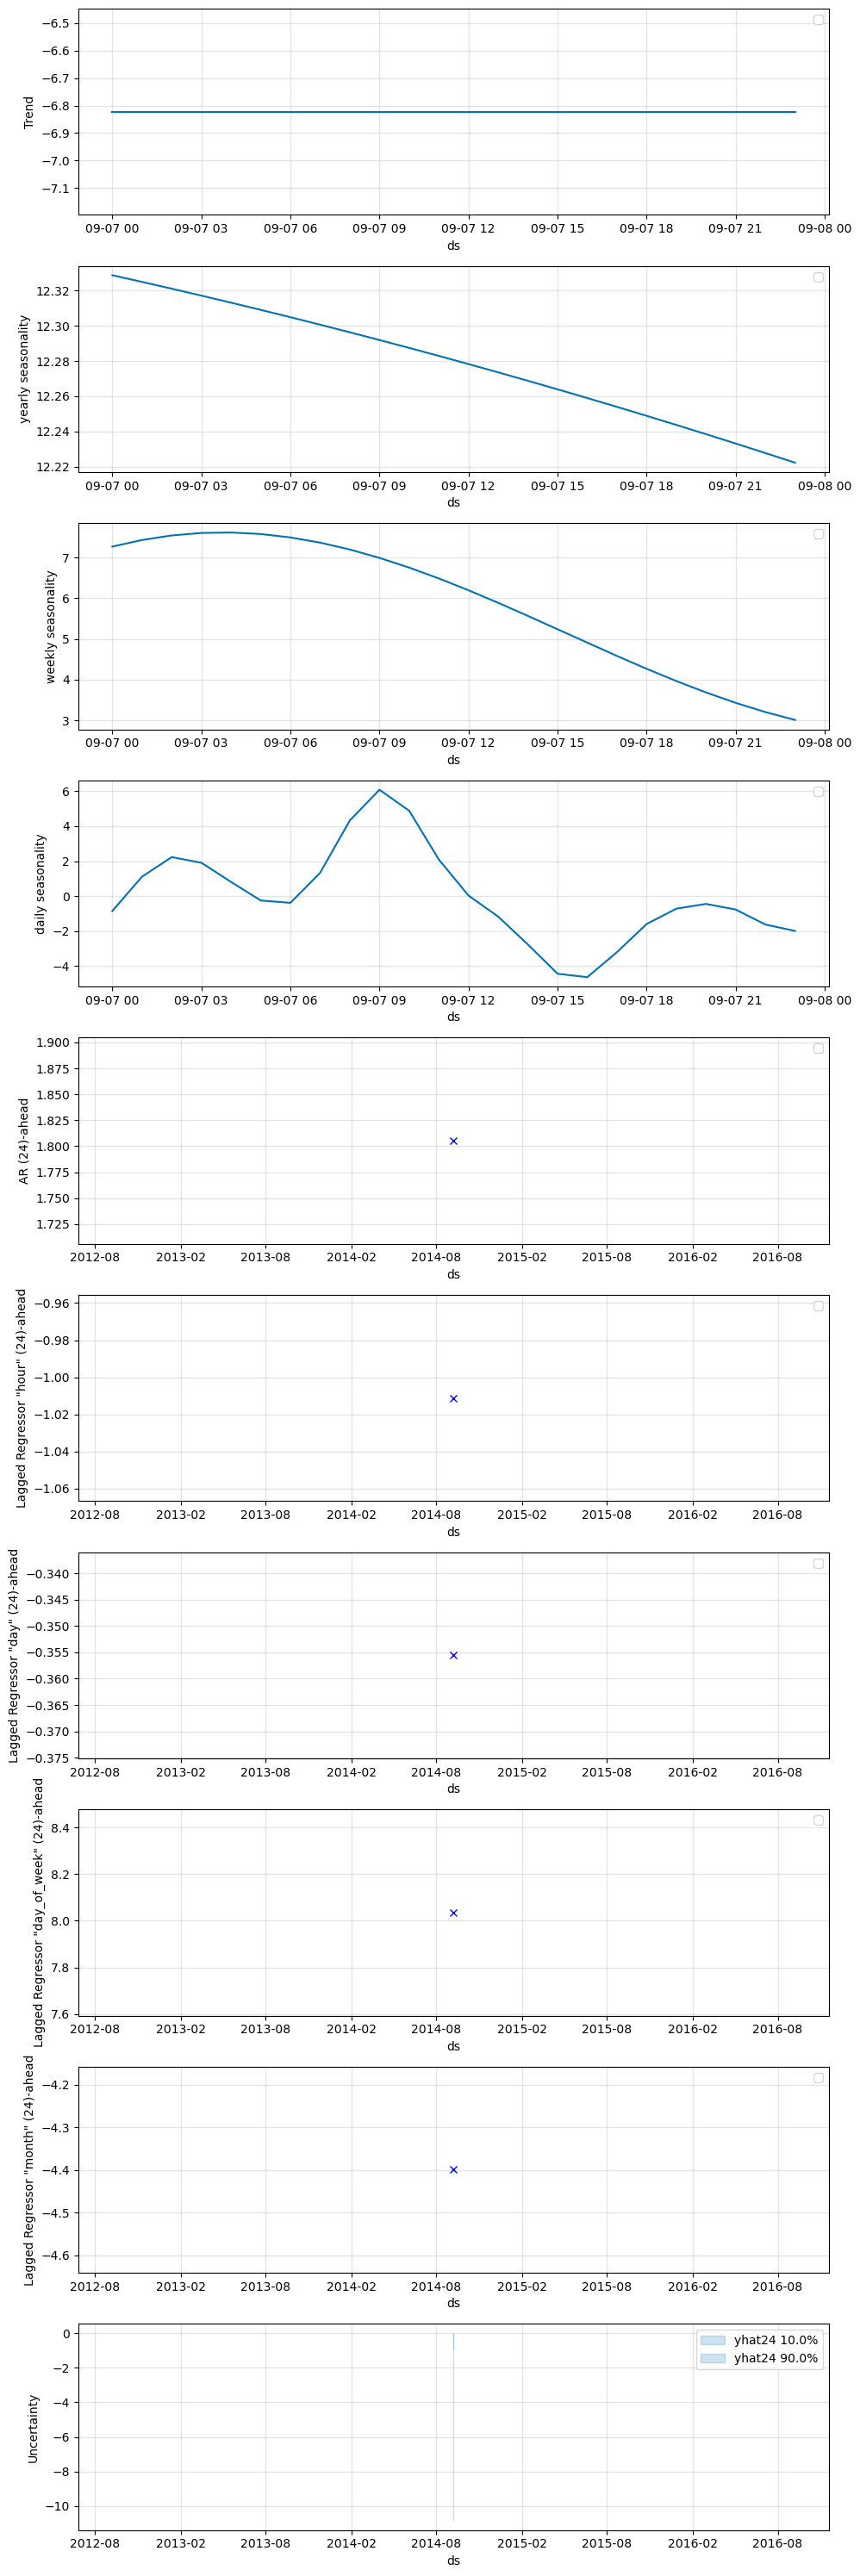

In [15]:
for id_nr in ["MT_001"], "MT_002", "MT_003", "MT_004", "MT_005"]:
    fig1 = model.plot(forecast[forecast["ID"] == id_nr])
    fig2 = model.plot_components(forecast[forecast["ID"] == id_nr])
type(fig2)

# 6. Conclusion

One of the major learnings we had, is, that models designed for production, are not as easy to use in a research enviroment than expected. While in real-world application, nobody is interested in the normalized values used inside the model, thus not making them readily accesible via the modules APIs. Both NeuralProphet and the TFT implementation have internal functions to handle those tasks, albeit we were not able to get them to work as intended. 
This creates the need to circumvent the build-in normalization and re-scale the data ourselves after predicting. The copied normalization from google,  

# 7. Bibliography 

[1] S. Li, et al., Enhancing the locality and breaking the memory bottleneck of transformer on time series forecasting, in: NeurIPS, 2019.

[2] Box, G. E. P., and G. C. Tiao. 1975. Intervention analysis with applications to economic and environmental problems. Journal of the American Statistical Association 70: 70-79.

[3] D. Salinas, V. Flunkert, J. Gasthaus, T. Januschowski, DeepAR: Probabilistic forecasting with autoregressive recurrent networks, International Journal of Forecasting, Volume 36, Issue 3,
2020, Pages 1181-1191, ISSN 0169-2070, https://doi.org/10.1016/j.ijforecast.2019.07.001. (https://www.sciencedirect.com/science/article/pii/S0169207019301888)